In [1]:
# import libraries
try:
  # %tensorflow_version only exists in Colab.
  !pip install tf-nightly
except Exception:
  pass
import tensorflow as tf
import pandas as pd
from tensorflow import keras
!pip install tensorflow-datasets
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import ReduceLROnPlateau

print(tf.__version__)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 633.9/633.9 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 52.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 73.8 MB/s eta 0:00:00
2.19.0-dev20250105


In [2]:
# get data files
!wget https://cdn.freecodecamp.org/project-data/sms/train-data.tsv
!wget https://cdn.freecodecamp.org/project-data/sms/valid-data.tsv

train_file_path = "train-data.tsv"
test_file_path = "valid-data.tsv"

--2025-01-06 08:30:51--  https://cdn.freecodecamp.org/project-data/sms/train-data.tsv
Resolving cdn.freecodecamp.org (cdn.freecodecamp.org)... 172.67.70.149, 104.26.3.33, 104.26.2.33, ...
Connecting to cdn.freecodecamp.org (cdn.freecodecamp.org)|172.67.70.149|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 358233 (350K) [text/tab-separated-values]
Saving to: ‘train-data.tsv’

train-data.tsv      100%[===================>] 349.84K  --.-KB/s    in 0.02s   

2025-01-06 08:30:51 (18.0 MB/s) - ‘train-data.tsv’ saved [358233/358233]

--2025-01-06 08:30:52--  https://cdn.freecodecamp.org/project-data/sms/valid-data.tsv
Resolving cdn.freecodecamp.org (cdn.freecodecamp.org)... 172.67.70.149, 104.26.3.33, 104.26.2.33, ...
Connecting to cdn.freecodecamp.org (cdn.freecodecamp.org)|172.67.70.149|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 118774 (116K) [text/tab-separated-values]
Saving to: ‘valid-data.tsv’

valid-data.tsv      100%[==========

In [33]:
text = open(train_file_path, 'rb').read().decode(encoding='utf-8')

#codename of unknown character or word
unknown = ['<PAD>', '<UNK>']

# build char indices
char_vocab = sorted(set(text))
char_vocab = unknown + char_vocab
# Creating a mapping from unique characters to indices
char2idx = {u:i for i, u in enumerate(char_vocab)}

def char_to_int(text):
  return np.array([char2idx.get(c, char2idx['<UNK>'])  for c in text])

# build word indices
word_vocab = sorted(set(text.split()))
word_vocab = unknown + word_vocab
word2idx = {u:i for i, u in enumerate(word_vocab)}

def word_to_int(text):
  return np.array([word2idx.get(w, word2idx['<UNK>']) for w in text])

In [34]:
train_df = pd.read_csv(train_file_path, sep='\t', header=None, names=['category','content'])
test_df = pd.read_csv(test_file_path, sep='\t', header=None, names=['category','content'])

numerical_train_df=pd.DataFrame()
numerical_train_df['category']=train_df['category'].map({'ham': 1, 'spam':0})
numerical_train_df['char_content']=train_df['content'].apply(char_to_int)
numerical_train_df['word_content']=train_df['content'].apply(lambda x: x.split()).apply(word_to_int)

In [35]:
numerical_test_df=pd.DataFrame()
numerical_test_df['category']=test_df['category'].map({'ham': 1, 'spam':0})
numerical_test_df['char_content']=test_df['content'].apply(char_to_int)
numerical_test_df['word_content']=test_df['content'].apply(lambda x: x.split()).apply(word_to_int)

In [36]:
char_txt_maxlen=np.quantile(numerical_train_df['char_content'].apply(len), 0.95).astype(int)
word_txt_maxlen=np.quantile(numerical_train_df['word_content'].apply(len), 0.95).astype(int)

In [37]:
char_train_df_padded = pad_sequences(numerical_train_df['char_content'], maxlen=char_txt_maxlen, padding='post', truncating='pre', dtype='int32')
word_train_df_padded = pad_sequences(numerical_train_df['word_content'], maxlen=word_txt_maxlen, padding='post', truncating='pre', dtype='int32')


In [48]:
def build_model():
    # char input
    char_input = tf.keras.layers.Input(shape=(char_txt_maxlen,), dtype=tf.int32, name='char_input_layer')
    char_embedding = tf.keras.layers.Embedding(input_dim=len(char_vocab), output_dim=128)(char_input)
    char_em_drop = tf.keras.layers.Dropout(0.5)(char_embedding)
    char_lstm_01 = tf.keras.layers.LSTM(128, return_sequences=True)(char_em_drop)
    char_lstm_02 = tf.keras.layers.LSTM(128, return_sequences=False)(char_lstm_01)

    # word input
    word_input = tf.keras.layers.Input(shape=(word_txt_maxlen,), dtype=tf.int32, name='word_input_layer')
    word_embedding = tf.keras.layers.Embedding(input_dim=len(word_vocab), output_dim=128)(word_input)
    word_em_drop = tf.keras.layers.Dropout(0.5)(word_embedding)
    word_lstm_01 = tf.keras.layers.LSTM(128, return_sequences=True)(word_em_drop)
    word_lstm_02 = tf.keras.layers.LSTM(128, return_sequences=False)(word_lstm_01)

    #merge char and word features
    merged_features = tf.keras.layers.concatenate([char_lstm_02, word_lstm_02])

    #dense
    dense_01 = tf.keras.layers.Dense(128, activation='relu')(merged_features)
    dropout_01 = tf.keras.layers.Dropout(0.5)(dense_01)
    dense_02 = tf.keras.layers.Dense(64, activation='relu')(dropout_01)
    dropout_02 = tf.keras.layers.Dropout(0.5)(dense_02)

    #output
    output=tf.keras.layers.Dense(1, activation='sigmoid', kernel_regularizer=keras.regularizers.l2(0.0001))(dropout_02)

    model=keras.Model(inputs=[char_input, word_input], outputs=output)

    optimizer = tf.keras.optimizers.AdamW(0.00001)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    return model

In [49]:
model=build_model()
model.summary()

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ char_input_layer          │ (None, 160)            │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ word_input_layer          │ (None, 32)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_12 (Embedding)  │ (None, 160, 128)       │         10,624 │ char_input_layer[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_13 (Embedding)  │ (None, 32, 128)        │      1,450,496 │ word_input_layer[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_12 (Dropout)      │ (None, 160, 128)       │              0 │ embedding_12[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_13 (Dropout)      │ (None, 32, 128)        │              0 │ embedding_13[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_16 (LSTM)            │ (None, 160, 128)       │        131,584 │ dropout_12[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_18 (LSTM)            │ (None, 32, 128)        │        131,584 │ dropout_13[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_17 (LSTM)            │ (None, 128)            │        131,584 │ lstm_16[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_19 (LSTM)            │ (None, 128)            │        131,584 │ lstm_18[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_6             │ (None, 256)            │              0 │ lstm_17[0][0],         │
│ (Concatenate)             │                        │                │ lstm_19[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_14 (Dense)          │ (None, 128)            │         32,896 │ concatenate_6[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_14 (Dropout)      │ (None, 128)            │              0 │ dense_14[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_15 (Dense)          │ (None, 64)             │          8,256 │ dropout_14[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_15 (Dropout)      │ (None, 64)             │              0 │ dense_15[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_16 (Dense)          │ (None, 1)              │             65 │ dropout_15[0][0]       │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 2,028,673 (7.74 MB)

 Trainable params: 2,028,673 (7.74 MB)

 Non-trainable params: 0 (0.00 B)

In [50]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=20, min_lr=1e-9, verbose=1)

# stop training if no improvement of val_loss when reaches 'patience' epochs
early_stop = keras.callbacks.EarlyStopping(monitor="val_loss", patience=20, verbose=1)

class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 ==0: print('')
    print('.', end='')

model = build_model()

history = model.fit(x=[char_train_df_padded, word_train_df_padded],
                    y=numerical_train_df['category'].values,
                    epochs=100,
                    validation_split=0.2,
                    verbose=0,
                    batch_size=64,
                    shuffle=True,
                    callbacks=[reduce_lr, early_stop, PrintDot()]
                    )


.............................................................................
Epoch 78: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-07.
.Epoch 78: early stopping


In [51]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.plot(hist['epoch'], hist['accuracy'],
           label='Train accuracy')
  plt.plot(hist['epoch'], hist['val_accuracy'],
           label = 'Val accuracy')

  plt.legend()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.plot(hist['epoch'], hist['loss'],
           label='Train loss')
  plt.plot(hist['epoch'], hist['val_loss'],
           label = 'Val loss')

  plt.legend()
  plt.show()

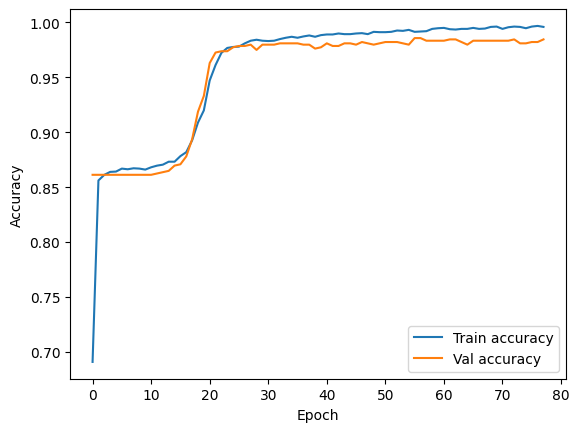

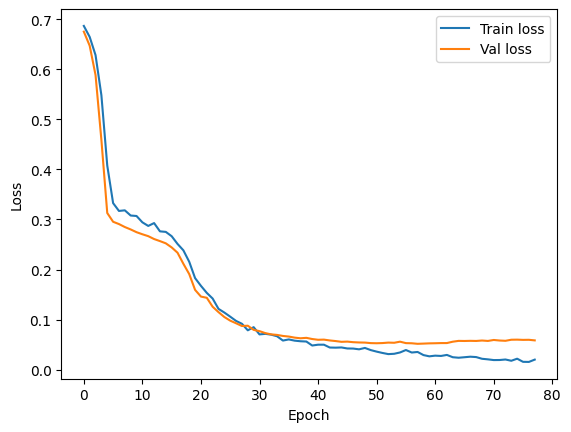

In [52]:
plot_history(history)

In [53]:
char_test_df_padded = pad_sequences(numerical_test_df['char_content'], maxlen=char_txt_maxlen, padding='post', truncating='pre', dtype='int32')
word_test_df_padded = pad_sequences(numerical_test_df['word_content'], maxlen=word_txt_maxlen, padding='post', truncating='pre', dtype='int32')


In [54]:
test_final_features = [char_test_df_padded, word_test_df_padded]

In [55]:
loss, accuracy = model.evaluate(test_final_features, numerical_test_df['category'].values, verbose=2)
print(f'loss is: {loss:.4f}, accuracy is: {accuracy*100:.2f}%')

44/44 - 0s - 8ms/step - accuracy: 0.9849 - loss: 0.0550
loss is: 0.0550, accuracy is: 98.49%


In [56]:
# function to predict messages based on model
# (should return list containing prediction and label, ex. [0.008318834938108921, 'ham'])
def predict_message(pred_text):
  prediction=[]
  c=char_to_int(pred_text)
  c=pad_sequences(c.reshape(1,-1), maxlen=char_txt_maxlen, padding='post', truncating='pre', dtype='int32')
  w=word_to_int(pred_text.split())
  w=pad_sequences(w.reshape(1,-1), maxlen=word_txt_maxlen, padding='post', truncating='pre', dtype='int32')

  pred_likeliness = model.predict([c,w])
  if pred_likeliness[0][0] > 0.5:
     prediction = [pred_likeliness[0][0], 'ham']
  else:
     prediction = [pred_likeliness[0][0], 'spam']

  return (prediction)

pred_text = "how are you doing today?"

prediction = predict_message(pred_text)
print(prediction)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step
[0.99995923, 'ham']


In [57]:
# Run this cell to test your function and model. Do not modify contents.
def test_predictions():
  test_messages = ["how are you doing today",
                   "sale today! to stop texts call 98912460324",
                   "i dont want to go. can we try it a different day? available sat",
                   "our new mobile video service is live. just install on your phone to start watching.",
                   "you have won £1000 cash! call to claim your prize.",
                   "i'll bring it tomorrow. don't forget the milk.",
                   "wow, is your arm alright. that happened to me one time too"
                  ]

  test_answers = ["ham", "spam", "ham", "spam", "spam", "ham", "ham"]
  passed = True

  for msg, ans in zip(test_messages, test_answers):
    prediction = predict_message(msg)
    if prediction[1] != ans:
      passed = False

  if passed:
    print("You passed the challenge. Great job!")
  else:
    print("You haven't passed yet. Keep trying.")

test_predictions()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
You passed the challenge. Great job!
